# Terra em Foco Conference: Introduction to Sentinel Hub APIs in CDSE: Part One

*This notebook was written for a two hour training session at the Terra em Foco, the Portuguese Earth Observation National Conference held in Braga, Portugal 12-13th September 2024.*

The Copernicus Data Space Ecosystem offers immediate access to large amounts of open and free Earth observation data from the Copernicus Sentinel satellites, including both new and historical Sentinel images, as well as Copernicus Contributing Missions. As the effects of climate change intensifies, the use of earth observation data will become ever more important to monitor wildfires in the southern Europe including Portugal. These two notebooks will show how you can utilise Copernicus data to do just this.

The Copernicus Data Space Ecosystem supports users in accessing, viewing, using, downloading, and analyzing data. The Copernicus Data Space Ecosystem is set up to further improve access and exploitation of the EU’s Copernicus satellites data. The service aims to support users in building various applications needed to provide accurate, timely and objective information which are crucial to create a more sustainable future.

The Copernicus Data Space Ecosystem offers multiple Application Programming Interfaces (APIs) ranging from catalogue, product download, visualization over processing web services such as STAC, openEO and Sentinel Hub APIs. This Jupyter notebook focuses on the Sentinel Hub APIs The Sentinel Hub API is a RESTful API interface that provides access to various satellite imagery archives. It allows you to access raw satellite data, rendered images, statistical analysis, and other features.


This notebook contains three examples:

1. Forest fire detection across south west Portugal utilising Sentinel-3 SLSTR
2. Visualisation of the forest fire during the event using Sentinel-2
3. Detection and mapping of the burned area post event

**Note:** You do not need any prior experience of Sentinel Hub APIs to be able to follow the functions in this notebook. However, it is advised that you should have some basic knowledge of python and its data science libraries.

Firstly, before getting started we should import some libraries. In addition, to common data science libraries we will be utilising the [Sentinel Hub Python package](https://sentinelhub-py.readthedocs.io/en/latest/index.html). This comes preinstalled in the Copernicus Data Space Ecosystem Jupyter Lab. 

In [1]:
# General utilities
import warnings
from typing import Any, Optional, Tuple

# Plotting
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Sentinel Hub services
from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    MimeType,
    SentinelHubRequest,
    SHConfig,
)
from shapely.geometry import shape

warnings.filterwarnings("ignore")
%matplotlib inline

/Users/williamray/miniconda3/envs/sentinelhub_base/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In the following cell, we have defined a python function to help us process and visualise the data later on in the notebook:

In [2]:
def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

## Authentication

You can obtain the credentials for the Sentinel Hub services (`client_id` & `client_secret`) in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the user settings, you can create a new OAuth client to generate these credentials. You can find more detailed instructions on the corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions for configuring your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions, you can create a profile specifically tailored to use the package to access the Copernicus Data Space Ecosystem data collections. This is useful because changes to the Config class in your notebook are usually only temporary. If you save the configuration in your profile, you do not have to generate new credentials or overwrite/change the default profile every time you start or write a new Jupyter notebook.

If you are using the Sentinel Hub Python package for the Copernicus Data Space Ecosystem for the first time, you should create a profile specifically for the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [ ]:
# Only run this cell if you have not created a configuration.

# config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
# config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
# config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `<profile_name>`.

In [3]:
config = SHConfig("cdse")

## 1: Forest fire detection across south west Portugal utilising Sentinel-3 SLSTR

In this first example, we will make a processing API request to visualise hotspots using Sentinel-3 SLSTR. 

Firstly, some information about the AOI and the case study that we will be using for this training. The AOI is located in south west Portugal and was the site of a wildfire in August 2023. Located near the town of Odemira, over 7000 hectares was burnt resulting in the evacuation of 1400 people as over 1000 firefighters were drafted in to fight and control the spread of the fire. [1](https://www.theguardian.com/world/2023/aug/08/firefighters-tackling-blaze-raging-in-southern-portugal-fire) [2](https://www.reuters.com/world/europe/more-than-1000-evacuated-portugal-wildfire-spreads-2023-08-08/)

In [4]:
area_of_interest = """{
  "type": "Polygon",
  "coordinates": [
    [
      [
        -8.920627,
        37.274053
      ],
      [
        -8.178291,
        37.274053
      ],
      [
        -8.178291,
        37.810869
      ],
      [
        -8.920627,
        37.810869
      ],
      [
        -8.920627,
        37.274053
      ]
    ]
  ]
}
"""

aoi = gpd.read_file(area_of_interest)
aoi["geometry"] = aoi
aoi["area"] = aoi.area
aoi.explore("area", color="Green", legend=False)

If you wish to make your own area of interest you can use the [Request Builder](https://shapps.dataspace.copernicus.eu/requests-builder/) application and draw and AOI using the interface before exporting it into your directory. You can then copy and paste the `geojson` contents into the `area_of_interest` variable in the cell above. 

In [5]:
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

### Processing API

The [Processing API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html) (or shortly "Process API") is the most commonly used API in Sentinel Hub as it provides images based on satellite data. Users can request raw satellite data, simple band combinations such as false colour composites, calculations of simple remote sensing indices like NDVI, or more advanced processing such as calculation of Leaf area index (LAI).

Even though satellite imagery data are often distributed in "tiles", we do not want users to be limited to these. Tiles are an artificially introduced entity to make data distribution easier to handle. However, users should not have to care about whether their AOI is on one tile or another, or perhaps on the border of two tiles. This is why Sentinel Hub API hides this complexity and simply makes the data available over chosen area of interest and temporal period of interest. Tiles are therefore automatically stitched together based on defined parameters (AOI, time period, cloud coverage, priority, etc., depending on the data type).

### Write an Evalscript

An [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html) (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any process, batch processing or OGC request.

In the following Evalscript we will perform all the processing steps that we performed in the "traditional" approach.

In [6]:
evalscript_fire_detection = """
// high accuracy Detect active fire points 
//Sentinel-3 SLSTR
//by Tiznger startup co
//www.tiznegar.com

var SAHM= ((S6 - S5) / (S6 + S5));

if(SAHM>.05 && S1<.23){
  return[5*S3, 1*S2, 1*S1]
}

else {
 return [S6,S3,S2]
}

//Red color indicates active fire areas and points
"""

### Build the request

We build the request according to the [API Reference](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). An evalscript (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any [process](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html), [batch processing](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Batch.html) or [OGC request](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/OGC.html).

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and its size (size or resolution).
- `mosaickingOrder` (optional): in this example we have used `leastRecent` which will return pixels from the least recent acquisition in the specified time period.


In [7]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_fire_detection,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL3_SLSTR.define_from(
                name="s3", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2023-08-06", "2023-08-06"),
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=full_geometry,
    size=[1000, 920],
    config=config,
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [8]:
true_color_imgs = request_true_color.get_data()

In [9]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (920, 1000, 3)


Image type: uint8


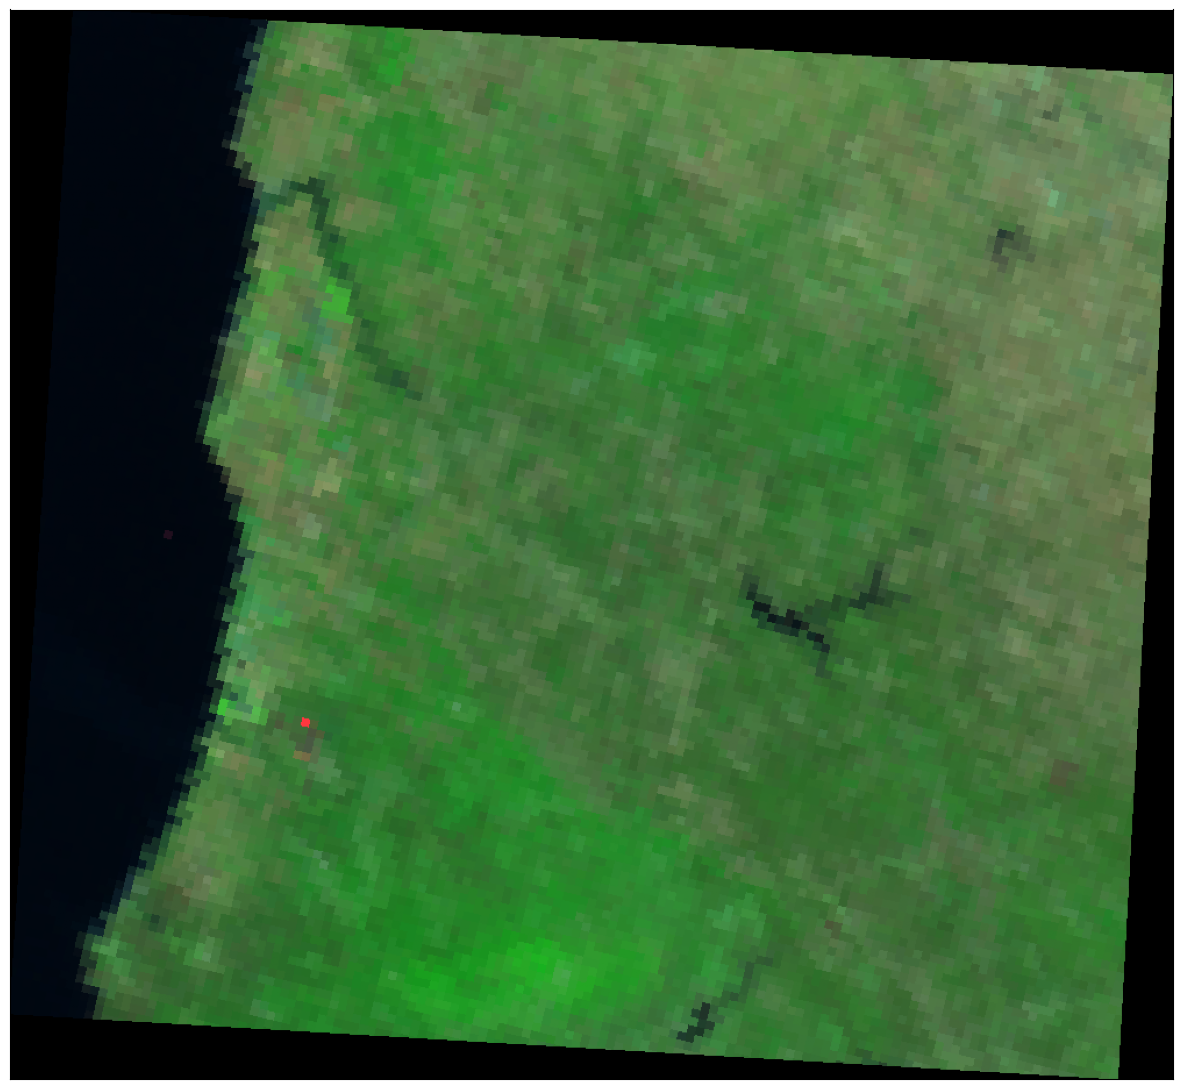

In [10]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
plot_image(image, factor=1.5 / 255, clip_range=(0, 1))

## 2: Visualising forest fires using Sentinel-2 imagery

In this second example, we will visualise the wildfire we detected using Sentinel-2 imagery.

### Write an Evalscript

An [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html) (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any process, batch processing or OGC request.

In the following Evalscript we will visualise the forest fire using the SWIR bands that Sentinel-2 offers. It's important to note this is just a visualisation to illustrate the forest fire. 

In [11]:
evalscript_wildfire_visualisation = """
// VERSION=3
// QuickFire V1.0.0 by Pierre Markuse (https://twitter.com/Pierre_Markuse)
// Adjusted for use in the Copernicus Browser (https://dataspace.copernicus.eu/browser/)
// CC BY 4.0 International (https://creativecommons.org/licenses/by/4.0/)

// Copernicus Browser does not have the band CLP, this was replaced with the isCloud() function
// but do try to turn off cloudAvoidance if results aren't as expected.

function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B8A", "B11", "B12", "dataMask"],
        output: { bands: 4 }
    };
}

function isCloud(samples) {
    const NGDR = index(samples.B03, samples.B04);
    const bRatio = (samples.B03 - 0.175) / (0.39 - 0.175);
    return bRatio > 1 || (bRatio > 0 && NGDR > 0);
}

function stretch(val, min, max) { return (val - min) / (max - min); }

function satEnh(arr, s) {
    var avg = arr.reduce((a, b) => a + b, 0) / arr.length;
    return arr.map(a => avg * (1 - s) + a * s);
}

function layerBlend(lay1, lay2, lay3, op1, op2, op3) {
    return lay1.map(function (num, index) {
        return (num / 100 * op1 + (lay2[index] / 100 * op2) + (lay3[index] / 100 * op3));
    });
}

function evaluatePixel(sample) {
    const hsThreshold = [2.0, 1.5, 1.25, 1.0];
    const hotspot = 1;
    const style = 1;
    const hsSensitivity = 1.0;
    const boost = 1.2;

    const cloudAvoidance = 1;
    const avoidanceHelper = 0.8;

    const offset = -0.007;
    const saturation = 1.10;
    const brightness = 1.40;
    const sMin = 0.15;
    const sMax = 0.99;

    const showBurnscars = 0;
    const burnscarThreshold = -0.25;
    const burnscarStrength = 0.3;

    const NDWI = (sample.B03 - sample.B08) / (sample.B03 + sample.B08);
    const NDVI = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    const waterHighlight = 0;
    const waterBoost = 2.0;
    const NDVI_threshold = 0.05;
    const NDWI_threshold = 0.0;
    const waterHelper = 0.1;

    const Black = [0, 0, 0];
    const NBRindex = (sample.B08 - sample.B12) / (sample.B08 + sample.B12);
    const naturalColorsCC = [Math.sqrt(brightness * sample.B04 + offset), Math.sqrt(brightness * sample.B03 + offset), Math.sqrt(brightness * sample.B02 + offset)];
    const naturalColors = [(2.5 * brightness * sample.B04 + offset), (2.5 * brightness * sample.B03 + offset), (2.5 * brightness * sample.B02 + offset)];
    const URBAN = [Math.sqrt(brightness * sample.B12 * 1.2 + offset), Math.sqrt(brightness * sample.B11 * 1.4 + offset), Math.sqrt(brightness * sample.B04 + offset)];
    const SWIR = [Math.sqrt(brightness * sample.B12 + offset), Math.sqrt(brightness * sample.B8A + offset), Math.sqrt(brightness * sample.B04 + offset)];
    const NIRblue = colorBlend(sample.B08, [0, 0.25, 1], [[0 / 255, 0 / 255, 0 / 255], [0 / 255, 100 / 255, 175 / 255], [150 / 255, 230 / 255, 255 / 255]]);
    const classicFalse = [sample.B08 * brightness, sample.B04 * brightness, sample.B03 * brightness];
    const NIR = [sample.B08 * brightness, sample.B08 * brightness, sample.B08 * brightness];
    const atmoPen = [sample.B12 * brightness, sample.B11 * brightness, sample.B08 * brightness];
    var enhNaturalColors = [0, 0, 0];
    for (let i = 0; i < 3; i += 1) { enhNaturalColors[i] = (brightness * ((naturalColors[i] + naturalColorsCC[i]) / 2) + (URBAN[i] / 10)); }

    const manualCorrection = [0.04, 0.00, -0.05];

    var Viz = layerBlend(URBAN, SWIR, naturalColorsCC, 10, 10, 90); // Choose visualization(s) and opacity here

    if (waterHighlight) {
        if ((NDVI < NDVI_threshold) && (NDWI > NDWI_threshold) && (sample.B04 < waterHelper)) {
            Viz[1] = Viz[1] * 1.2 * waterBoost + 0.1;
            Viz[2] = Viz[2] * 1.5 * waterBoost + 0.2;
        }
    }

    Viz = satEnh(Viz, saturation);
    for (let i = 0; i < 3; i += 1) {
        Viz[i] = stretch(Viz[i], sMin, sMax);
        Viz[i] += manualCorrection[i];
    }

    if (hotspot) {
        if ((!cloudAvoidance) || (!isCloud(sample) && (sample.B02 < avoidanceHelper))) {
            switch (style) {
                case 1:
                    if ((sample.B12 + sample.B11) > (hsThreshold[0] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.50 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    if ((sample.B12 + sample.B11) > (hsThreshold[1] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.20 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    if ((sample.B12 + sample.B11) > (hsThreshold[2] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.10 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.00 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    break;
                case 2:
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [1, 0, 0, sample.dataMask];
                    break;
                case 3:
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [1, 1, 0, sample.dataMask];
                    break;
                case 4:
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [Viz[0] + 0.2, Viz[1] - 0.2, Viz[2] - 0.2, sample.dataMask];
                    break;
                default:
            }
        }
    }

    if (showBurnscars) {
        if (NBRindex < burnscarThreshold) {
            Viz[0] = Viz[0] + burnscarStrength;
            Viz[1] = Viz[1] + burnscarStrength;
        }
    }

    return [Viz[0], Viz[1], Viz[2], sample.dataMask];
}
"""

### Build the request

We build the request according to the [API Reference](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). An evalscript (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any [process](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html), [batch processing](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Batch.html) or [OGC request](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/OGC.html).

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and its size (size or resolution).
- `mosaickingOrder` (optional): in this example we have used `leastRecent` which will return pixels from the least recent acquisition in the specified time period.


In [12]:
request_wildfire_visualisation = SentinelHubRequest(
    evalscript=evalscript_wildfire_visualisation,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2023-08-07", "2023-08-07"),
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=full_geometry,
    size=[1000, 920],
    config=config,
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [13]:
imgs = request_wildfire_visualisation.get_data()

In [14]:
print(f"Returned data is of type = {type(imgs)} and length {len(imgs)}.")
print(
    f"Single element in the list is of type {type(imgs[-1])} and has shape {imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (920, 1000, 4)


Image type: uint8


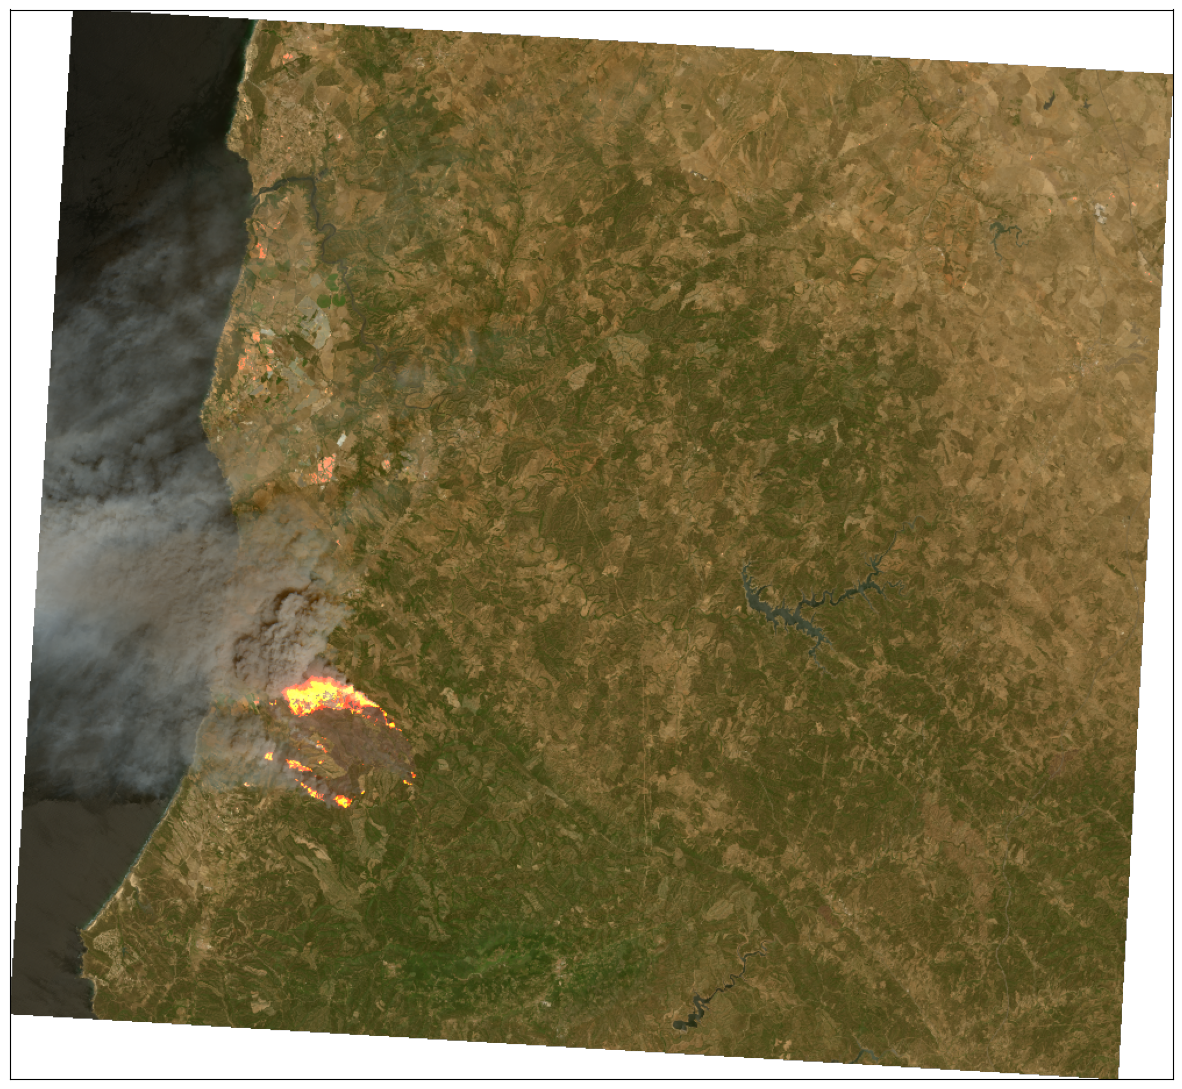

In [15]:
image = imgs[0]
print(f"Image type: {image.dtype}")

# plot function
plot_image(image, factor=1 / 255, clip_range=(0, 1))

## 3: Mapping and measuring the area of burn scars

Now we will focus on the post event, using the normalised burn ratio we can visualise the extent of the burn scar very easily. Let's create a more focussed area of interest to map out the burn scar area post event:

In [16]:
area_of_interest = """{
  "type": "Polygon",
  "coordinates": [
    [
      [
        -8.920627,
        37.362517
      ],
      [
        -8.516631,
        37.362517
      ],
      [
        -8.516631,
        37.628372
      ],
      [
        -8.920627,
        37.628372
      ],
      [
        -8.920627,
        37.362517
      ]
    ]
  ]
}
"""

aoi = gpd.read_file(area_of_interest)
aoi_simplified = aoi.geometry.simplify(0.001)
aoi["geometry"] = aoi_simplified
aoi["area"] = aoi.area
aoi.explore("area", color="Green", legend=False)

In [17]:
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

This time we have combined the evalscript and the API request into a single cell:

In [18]:
evalscript_burn_scar_map = """
//VERSION=3
// Burneed area detection
// Author: Monja B. Šebela

function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B11", "B12", "dataMask"],
        output: { bands: 4 }
      };
}

function evaluatePixel(samples) {
	var NDWI=index(samples.B03, samples.B08); 
	var NDVI=index(samples.B08, samples.B04);
	var INDEX= ((samples.B11 - samples.B12) / (samples.B11 + samples.B12))+(samples.B08);

  	if((INDEX>0.2)||(samples.B02>0.1)||(samples.B11<0.1)||(NDVI>0.3)||(NDWI > 0.1)){
  		return[2.5*samples.B04, 2.5*samples.B03, 2.5*samples.B02, samples.dataMask]
	}
	else {
 	return [1, 0, 0, samples.dataMask]
	}
}
"""

request_burn_scar_map = SentinelHubRequest(
    evalscript=evalscript_burn_scar_map,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2023-08-10", "2023-08-15"),
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=full_geometry,
    size=[1000, 920],
    config=config,
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [19]:
burn_scar_imgs = request_burn_scar_map.get_data()

In [21]:
print(
    f"Returned data is of type = {type(burn_scar_imgs)} and length {len(burn_scar_imgs)}."
)
print(
    f"Single element in the list is of type {type(burn_scar_imgs[-1])} and has shape {burn_scar_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (920, 1000, 4)


Image type: uint8


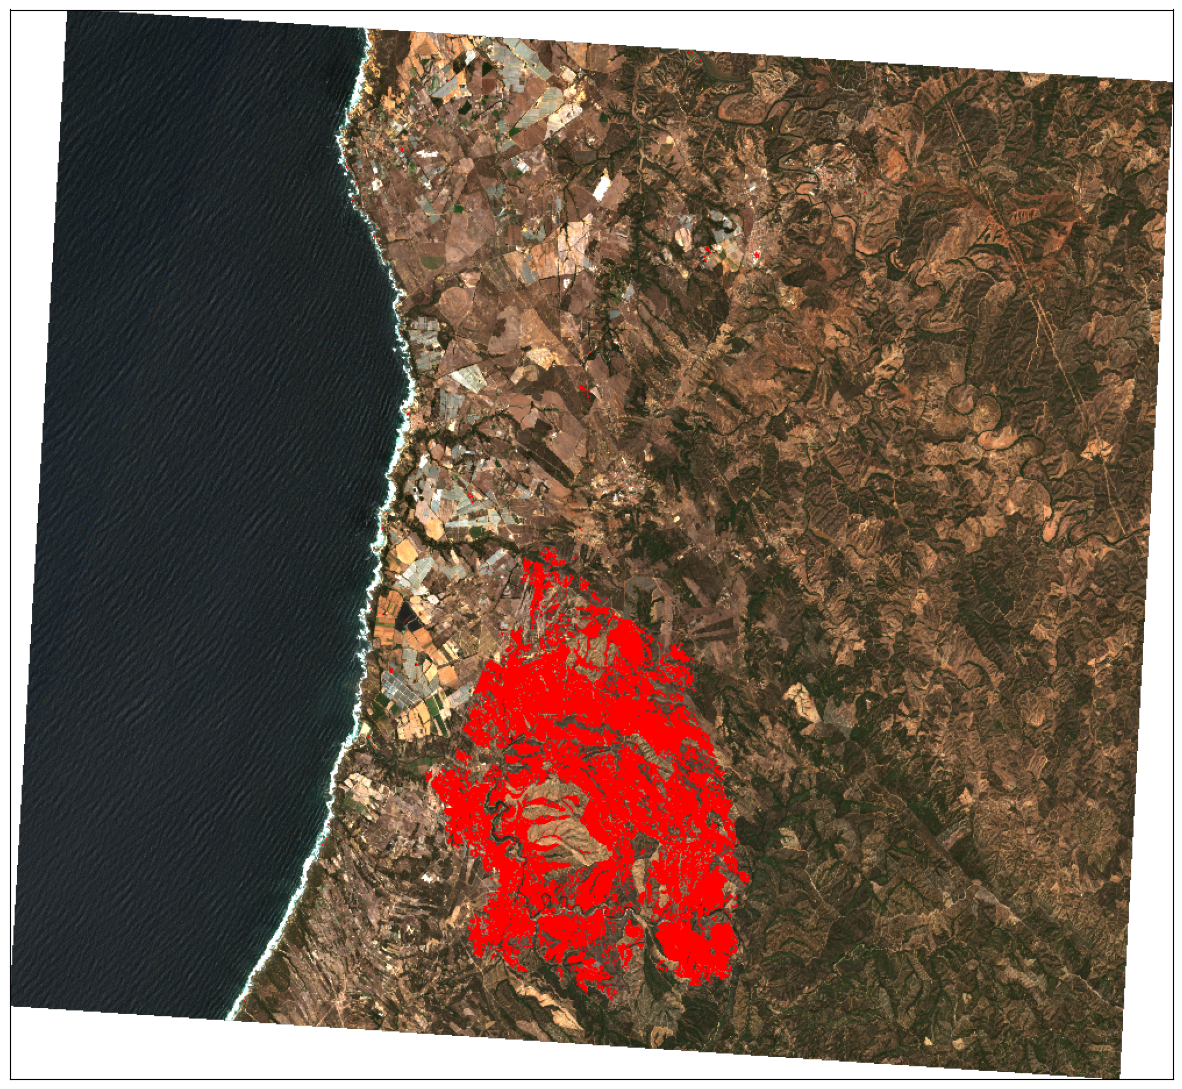

In [22]:
image = burn_scar_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
plot_image(image, factor=1.5 / 255, clip_range=(0, 1))

The detection of the burn scar is not perfect, but we can now see the spatial extent using the threshold we defined in the evalscript.

#### Exercise:

- Can you improve the detection of the burn scar in the above image? 
    - Hint: Can you find and adjust the parameter in the evalscript that does this or formulate your own method to do this.

- If you have time, are you able to find a way to map severely burned and moderately burned areas?